In [1]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install networkx numpy pandas statsmodels pygraphviz dowhy==0.10

In [2]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import statsmodels.api as sm
import dowhy
from typing import Set

import warnings
warnings.filterwarnings("ignore")

# Randomized Experiments

By Niccolò Rocchi and Fabio Stella

## Abstract

Randomized Controlled Trials (RCTs) are usually compared to observational studies in the way they may enable to discover causal effect properly. A "*perfect*" (i.e. unbiased) RCT ensures the statistical difference between outcomes in case and control groups to be the real causal effect, that is: association **is** causation.

In this notebook it is firstly presented a scenario in which all patients undergo a "*perfect*" randomized treatment, thus showing there's no need to adjust the causal estimand for any variable. In fact, in the randomized SCM the causal and statistical estimands coincide.

Afterwards, the RCT scope is enlarged. In particular, some references will be given about different types of RCTs experiment and some possible biases that may occur in real-world experiments. The latter shows why RCTs are not always unbiased.

Finally, it will be shown a common bias through a famous paradox, showing that not even randomization may help if data are collected badly.

## An ideal situation

We review the [example](https://colab.research.google.com/github/madlabunimib/F1801Q161-CausalNetworks/blob/main/notebooks/potential_outcomes.ipynb) of **sodium intake** and  **systolic blood pressure**. The data generation mechanism, that is the underlying SCM, is as follows:

In [3]:
def sample_data(size: int = int(1e6), seed: int = 31):
    # Set random generator seed for results reproducibility
    np.random.seed(seed)
    # Sample age with mean 65 and std 5
    age = np.random.normal(65, 5, size)
    # Sample sodium with additive noise
    sod = 0.056 * age + np.random.normal(0, 1, size)
    # Binarize sodium following cutoff
    sod = (sod > 3.5).astype(int)
    # Sample systolic blood pressure
    sbp = 1.05 * sod + 2 * age + np.random.normal(0, 1, size)
    # Sample urinary protein
    pro = 0.4 * sod + 0.3 * sbp + np.random.normal(0, 1, size)
    # Create a dataframe from sampled variables
    return pd.DataFrame({"AGE": age, "SOD": sod, "SBP": sbp, "PRO": pro})

Against any possible cost and ethic, image now we are able to assign or not a patient a certain quantity of daily sodium. If the assignment was performed like a coin toss, the new SCM would have this form:

In [4]:
def sample_data_RCT(size: int = int(1e6), seed: int = 31):
    # Set random generator seed for results reproducibility
    np.random.seed(seed)
    age = np.random.normal(65, 5, size)
    # Sample sodium in a randomized manner
    sod = np.random.binomial(1, 0.5, size)
    sbp = 1.05 * sod + 2 * age + np.random.normal(0, 1, size)
    pro = 0.4 * sod + 0.3 * sbp + np.random.normal(0, 1, size)
    return pd.DataFrame({"AGE": age, "SOD": sod, "SBP": sbp, "PRO": pro})

We generate data in one shot, but keep in mind the treatment is administered **after** the collection of patients. That is, the patient's covariates generation is **independent** from the treatment random assignment.

The formula by which we identify the causal estimand into a statistical one is the same, and it is the adjustment formula. However, in RCT experiments the causal estimand coincides with the statistical estimand, thus the estimation process reduces to model:

$$
\mathbb{E}[Y|X]
$$

by which we compute:

$$
\mathbb{E}[Y|X=1] -\mathbb{E}[Y|X=0]
$$

from data.

Define the ACE estimator, given an adjustment set of variables:

In [5]:
def ACE(data: pd.DataFrame, X: str, Y: str, Z: Set[str]):
    # Define the regresion model formula
    formula = f"{Y} ~ {X}"
    if len(Z) != 0: formula += "+" + "+".join(Z)
    # Fit Ordinary Least Square regression model
    estimator = sm.OLS.from_formula(formula, data).fit()
    # Compute potential outcomes by fixing X
    Y1 = estimator.predict(data.assign(**{X: 1}))
    Y0 = estimator.predict(data.assign(**{X: 0}))
    # Compute average causal effect
    return np.mean(Y1 - Y0)

The true ACE in the data generation process is:

In [6]:
ace = 1.05

In an observational study, we must adjust for known confounders. Anyway, what if we do not observe some of the confounders?

In [7]:
data = sample_data()
data.describe()

,AGE,SOD,SBP,PRO
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,65.001134,0.552995,130.583161,39.396720
std,4.993518,0.497184,10.161539,3.263477
min,40.964418,0.000000,82.816817,24.421988
25%,61.627703,0.000000,123.720103,37.190745
50%,65.009236,1.000000,130.597297,39.402344
75%,68.372794,1.000000,137.445514,41.602773
max,87.717317,1.000000,176.708462,54.573313


In [8]:
t = ACE(data, X = "SOD", Y = "SBP", Z = [])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 5.37, Relative Error: 411.5%'

In [9]:
t = ACE(data, X = "SOD", Y = "SBP", Z = ["AGE"])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 1.05, Relative Error: 0.2269%'

In a perfect RCT any observed and unobserved confounder does not bias the effect. The flow of association coincides with the flow of causation.

In [10]:
data_RCT = sample_data_RCT()
data_RCT.describe()

,AGE,SOD,SBP,PRO
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,65.001134,0.499142,130.525985,39.358272
std,4.993518,0.500000,10.048963,3.190841
min,40.964418,0.000000,82.154515,24.116208
25%,61.627703,0.000000,123.745198,37.202082
50%,65.009236,0.000000,130.542093,39.363281
75%,68.372794,1.000000,137.315558,41.514707
max,87.717317,1.000000,176.477008,54.653367


In [11]:
t = ACE(data_RCT, X = "SOD", Y = "SBP", Z = [])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 1.02, Relative Error: 3.092%'

If we have enough data, it is the same as computing the difference between two means, without the need to model the expected value $\mathbb{E}[Y|X]$:

In [12]:
np.mean(data_RCT[data_RCT["SOD"] == 1]["SBP"]) - np.mean(data_RCT[data_RCT["SOD"] == 0]["SBP"])

1.0175295115535619

Pay attention to the sample size: unbalanced classes may receive quite big differences in treatment assignment. In general, random assignment in low sample size may result in **no exchangeability** (or no ignorability) between case and control groups!

In [13]:
data_RCT = sample_data_RCT(size = 400)
data_RCT.describe()

,AGE,SOD,SBP,PRO
count,400.000000,400.000000,400.000000,400.000000
mean,64.591074,0.542500,129.837556,39.230748
std,5.156526,0.498814,10.467645,3.303568
min,52.174309,0.000000,104.690361,31.434524
25%,61.350871,0.000000,122.923145,37.088950
50%,64.335154,1.000000,129.237557,39.212511
75%,68.185394,1.000000,137.182062,41.551124
max,80.394038,1.000000,161.573823,48.686999


In [14]:
t = np.mean(data_RCT[data_RCT["SOD"] == 1]["SBP"]) - np.mean(data_RCT[data_RCT["SOD"] == 0]["SBP"])
f"Estimated ACE: {t:.3}, Relative Error: {(np.abs((t-ace)/ace*100)):.4}%"

'Estimated ACE: 2.29, Relative Error: 118.2%'

## Real World Evidence (RWE) and Randomized Controlled Trials (RCT): a false dicotomy

[This article](https://www.sciencedirect.com/science/article/pii/S0959804923001491) states the relevance of having RCT data in **clinical practice**, for their causal evidence. However, it is not true that all randomized experiments are the same. The paper gives an overview of the existing studies that combines observational and interventional (i.e. experimental) data.

## Biases in Randomization

Some RCT studies may be [biased](https://jnnp.bmj.com/content/75/2/181), due to how they are conducted by humans. Moreover, RCTs are in general too **costly**, **unethical** and may require **too long** to obtain robust results as in the case of rare illnesses. In this way, it is not a one-size-fits-all solution and one must pay attention to the general RCT study pipeline when reading any article.

We now show motivating example, expliciting the fact that randomization is not a panacea and even misleading if not caring about the underlying causal mechanisms. Here it is presented a famous **selection bias**: the Berkson's paradox. Selection bias generally occurs when data are collected conditionally to certain variable(s). If we block a confounding path from treatment to outcome, we should not worry about it during the estimation. Instead, if the conditioned variable **opens a collider**, then a spurious path is open.

Let's firstly define a plot style:

In [15]:
def draw(G, selection = []):
  plt.figure(figsize = (5, 4))
  pos = graphviz_layout(G, prog = "dot")

  for v in G.nodes():
    node_shape = "o"
    node_color = "white"
    if any(v in s for s in selection):
      node_shape = "s"
      node_color = "grey"
    nx.draw_networkx_nodes(
          G,
          pos = pos,
          nodelist = [v],
          node_shape = node_shape,
          node_color = node_color,
          node_size = 4e2,
          edgecolors = "black",
          margins = 0.2
        )
  nx.draw_networkx_labels(G, pos = pos, font_size = 15)
  nx.draw_networkx_edges(
          G,
          pos = pos,
          width = 1,
          arrowsize = 15,)

### Selection bias: the Berkson's paradox

Suppose we are interested in studying the causal effect of smoke ($S$) on lung cancer ($T$).

Now, it would be impossible to interview any possible smoker and non-smoker. Not only because their union would compose the whole population, but also because we should wait for healthy people to develop or not the illness.

For these reasons, **we ask a specialized Health Center** ($H$) to provide its already collected data. The center is a reference point in the smoking community, thus people go there either for stopping smoking or for being treated against cancer.

Formally speaking, we could model the situation as in the following SCM:

$$
\begin{cases}
S := Bern(0.3) \\
T := 0.25 \cdot S + Bern(0.2) \\
H := \max(S, T) ~\oplus~ Bern(0.1)
\end{cases}
$$

Note we have supposed $S$ to be random, thus not depending on any other variable. This is not realistic in general, but you may think about it as a randomized experiment. The resulting causal Bayesian network is:

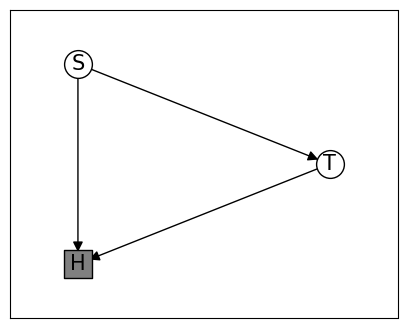

In [16]:
G = nx.DiGraph([("S", "H"), ("T", "H"), ("S", "T")])
nx.drawing.nx_pydot.write_dot(G, "G.dot")
draw(G, ["H"])

Now, suppose we generate all the population instancies following the SCM:

In [17]:
def sample_data(size: int = int(1e6), seed: int = 31):
    # Set random generator seed for results reproducibility
    np.random.seed(seed)
    # Sample variables according to the SCM
    smoking = np.random.binomial(1, 0.3, size)
    tumor = 1.05 * smoking + np.random.normal(0, 1, size)
    tumor = (tumor > 1).astype(int)
    hospital = (np.maximum(smoking, tumor) + np.random.binomial(1, 0.1, size)) % 2
    return pd.DataFrame({"S": smoking, "T": tumor, "H": hospital})

In [18]:
data = sample_data()
data.head()

,S,T,H
0,0,0,0
1,1,1,1
2,1,0,1
3,1,0,1
4,0,0,0


Now we focus on the Health center patients:

In [19]:
data_hospital = data[data["H"] == 1]

Now, we may look at the data generation as being an RCT, since $S$ is randomly generated in the SCM. Therefore, we may end up in estimating the causal effect in this way:

In [20]:
np.mean(data_hospital[data_hospital["S"] == 1]["T"]) - np.mean(data_hospital[data_hospital["S"] == 0]["T"])

-0.10764081482812993

The negative correlation between smoke and lung cancer is because of the open collider, and wrongly attributed to the causal effect. In fact, by selecting hospitalized patients, we are creating a non-causal association from $S$ to $T$.

There is no causal tool that may disentangle causal and non-causal flow here, ending up in wrong conclusions for the ATE.

Do you really think that smoking has a protective role against lung cancer?

In [21]:
model = dowhy.CausalModel(
    data = data_hospital,
    treatment = "S",
    outcome = "T",
    graph = "./G.dot"
)

In [22]:
estimand = model.identify_effect(proceed_when_unidentifiable = True)
estimator = "backdoor.linear_regression"
estimate = model.estimate_effect(estimand, method_name = estimator)

In [23]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[T])
d[S]      
Estimand assumption 1, Unconfoundedness: If U→{S} and U→T then P(T|S,,U) = P(T|S,)

## Realized estimand
b: T~S
Target units: ate

## Estimate
Mean value: -0.10764081482812926



However, by looking at the whole population, we do not introduce any selection bias. Notice that the selection bias is sometimes hard to identify, since it is often introduced not by purpose while carelessly collecting data at the origin.

In [24]:
np.mean(data[data["S"] == 1]["T"]) - np.mean(data[data["S"] == 0]["T"])

0.3609226235928648